# IMAGE RECONSTRUCTION VIA PCA, PPCA AND VARIATIONAL AUTOENCODER

## LOADING THE DATASET

In [1]:
from keras.datasets import mnist
import numpy as np

(trainImages, _), (testImages, _) = mnist.load_data()

trainImages, testImages = trainImages / 255.0, testImages / 255.0

#print("Training dimensions:", trainImages.shape)
#print("Test dimensions:", testImages.shape)

flattenedTrainImages = trainImages.reshape((trainImages.shape[0], -1))
flattenedTestImages = testImages.reshape((testImages.shape[0], -1))

print("Flattened training dimensions:", flattenedTrainImages.shape)
print("Flattened test dimensions:", flattenedTestImages.shape)

np.random.seed(42)      #To ensure that same images are used across pca and ppca. Change seed value for different images
selectedImages = np.random.choice(len(testImages), size = 5, replace=False)

Flattened training dimensions: (60000, 784)
Flattened test dimensions: (10000, 784)


## PCA IMPLEMENTATION

MSE for latent dimension 2 is: 0.05566949193442309


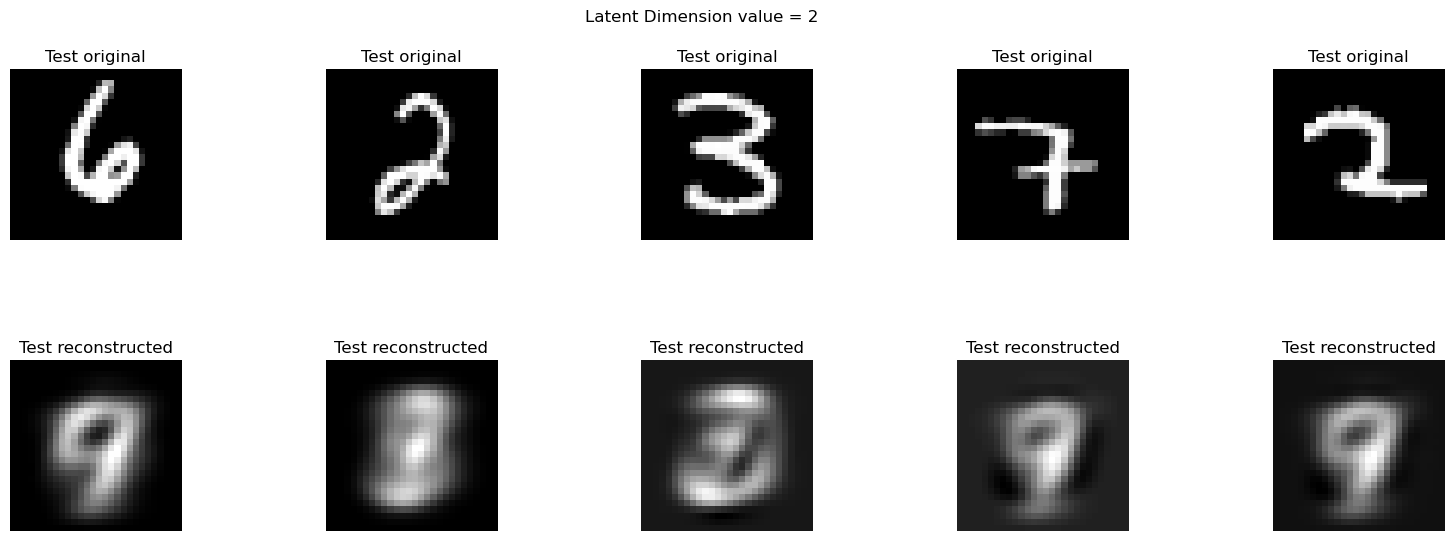

MSE for latent dimension 4 is: 0.04790346506558458


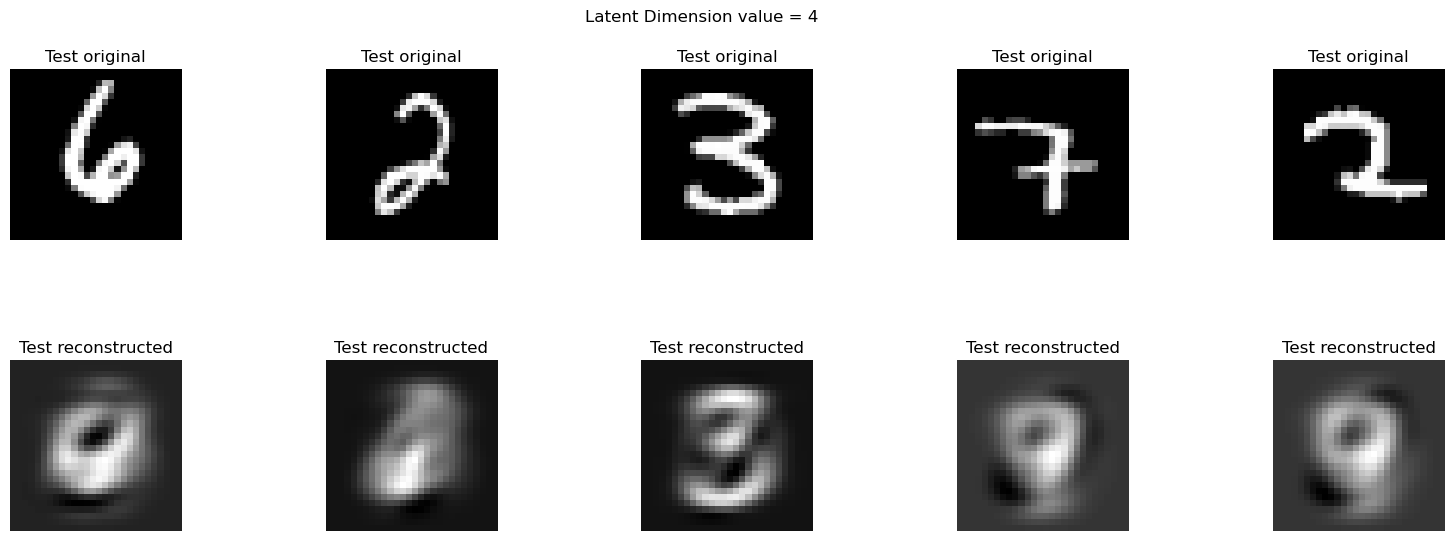

MSE for latent dimension 8 is: 0.03744093391903095


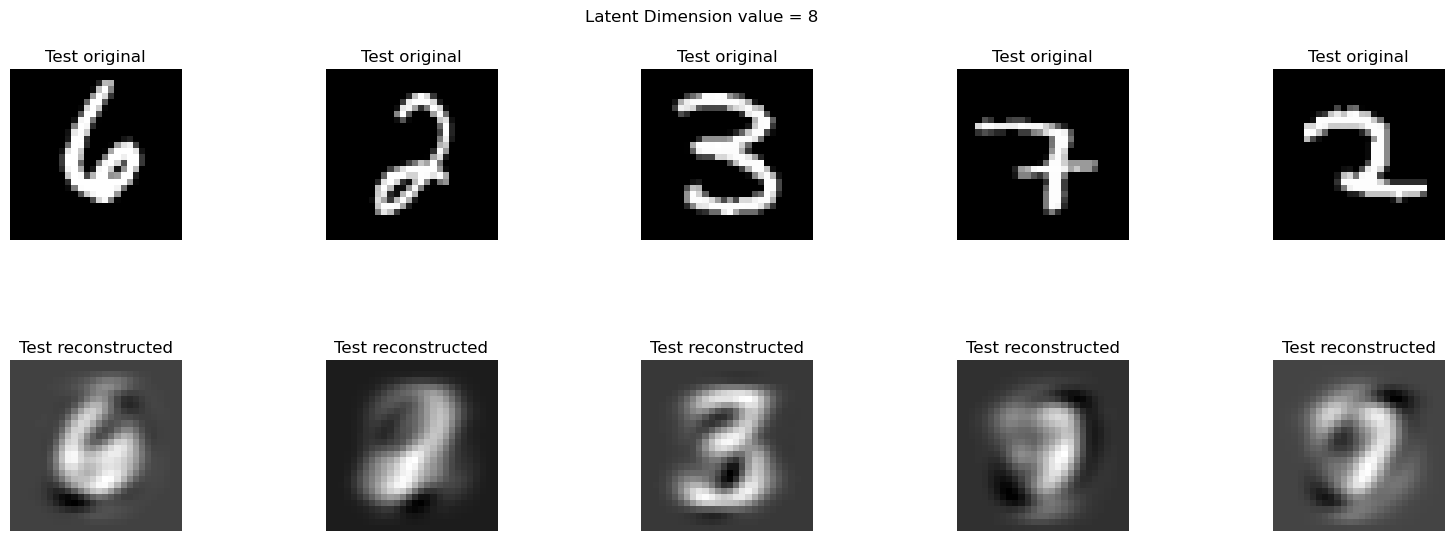

MSE for latent dimension 16 is: 0.02686019078827122


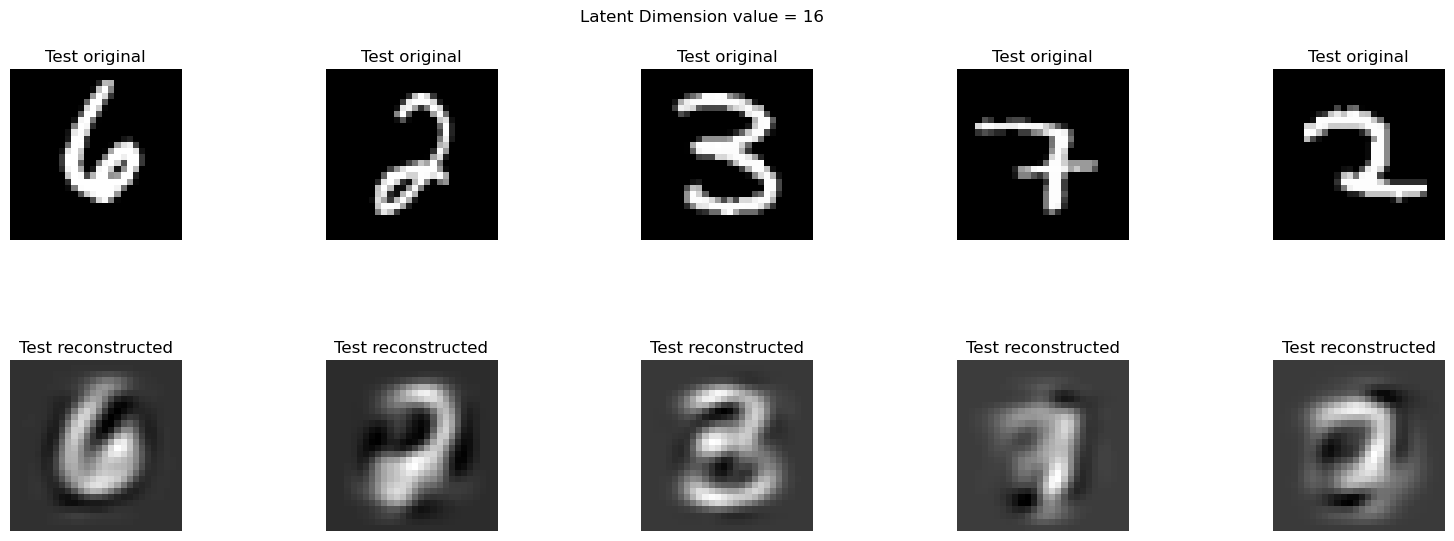

MSE for latent dimension 32 is: 0.016829987691859557


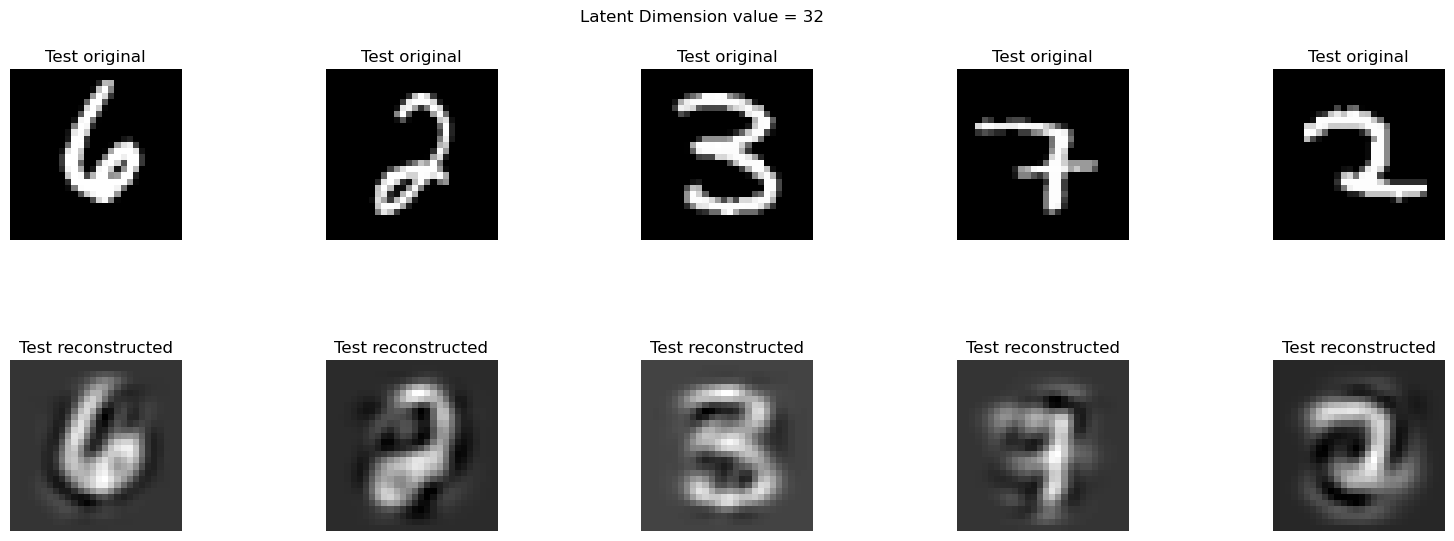

MSE for latent dimension 64 is: 0.009047770446754689


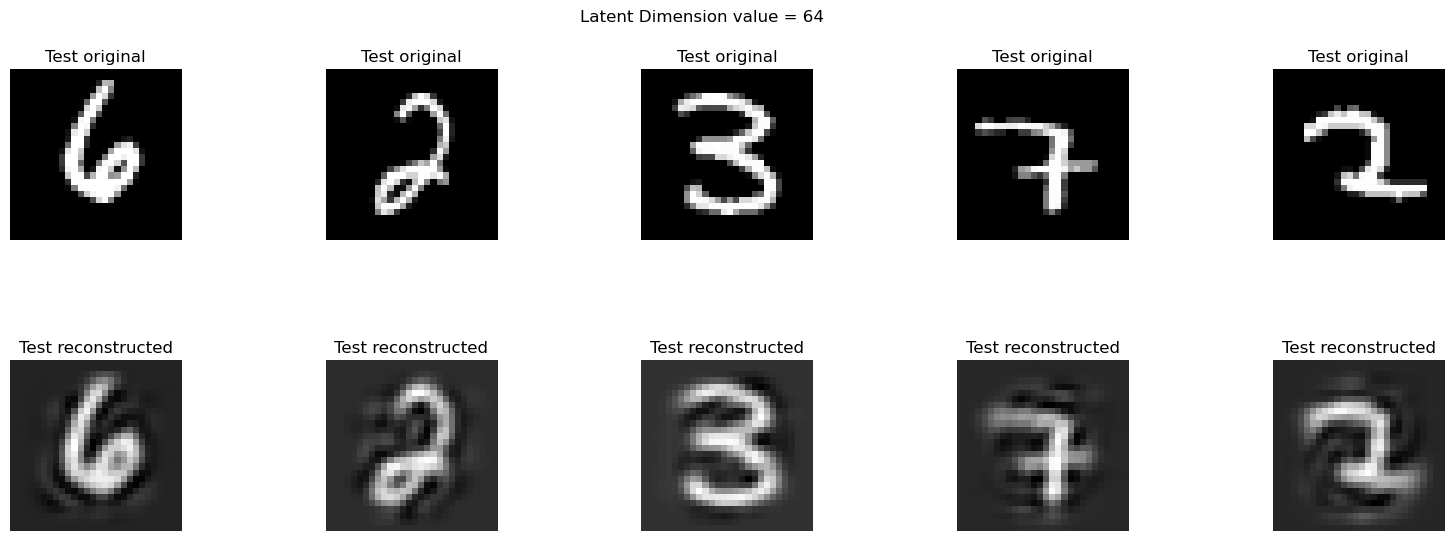

In [2]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64] 

def pcaFn(latentDimensionValue, flattenedTestImages):
    pca = PCA(n_components=latentDimensionValue)
    pca.fit(flattenedTrainImages)

    transformedImages = pca.inverse_transform(pca.transform(flattenedTestImages))
    transformedImages = transformedImages.reshape((-1, 28 * 28))    #Converting into 2d array

    return transformedImages

def pcaMSE(originalImages, reconstructedImages):
    return np.mean((originalImages - reconstructedImages)**2)

mse_values_list = []

for latentDimensionValue in latentDimensions:

    reconstructedImages = pcaFn(latentDimensionValue, flattenedTestImages)
    mseVal = pcaMSE(flattenedTestImages,reconstructedImages)
    mse_values_list.append(mseVal)
    
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent Dimension value = {latentDimensionValue}")
 
    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
mse_values_array = np.array(mse_values_list)


## PROBABILISTIC PCA IMPLEMENTATION

MSE val for latent dimension 2 is 0.06742457947489407


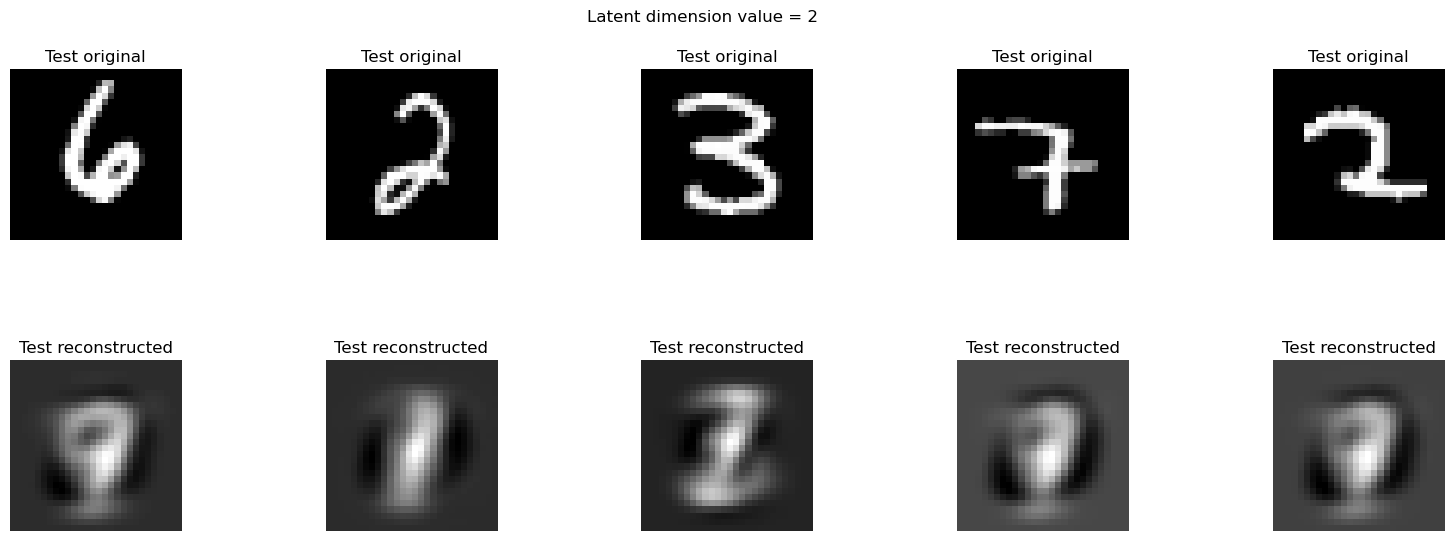

MSE val for latent dimension 4 is 0.06468975344922344


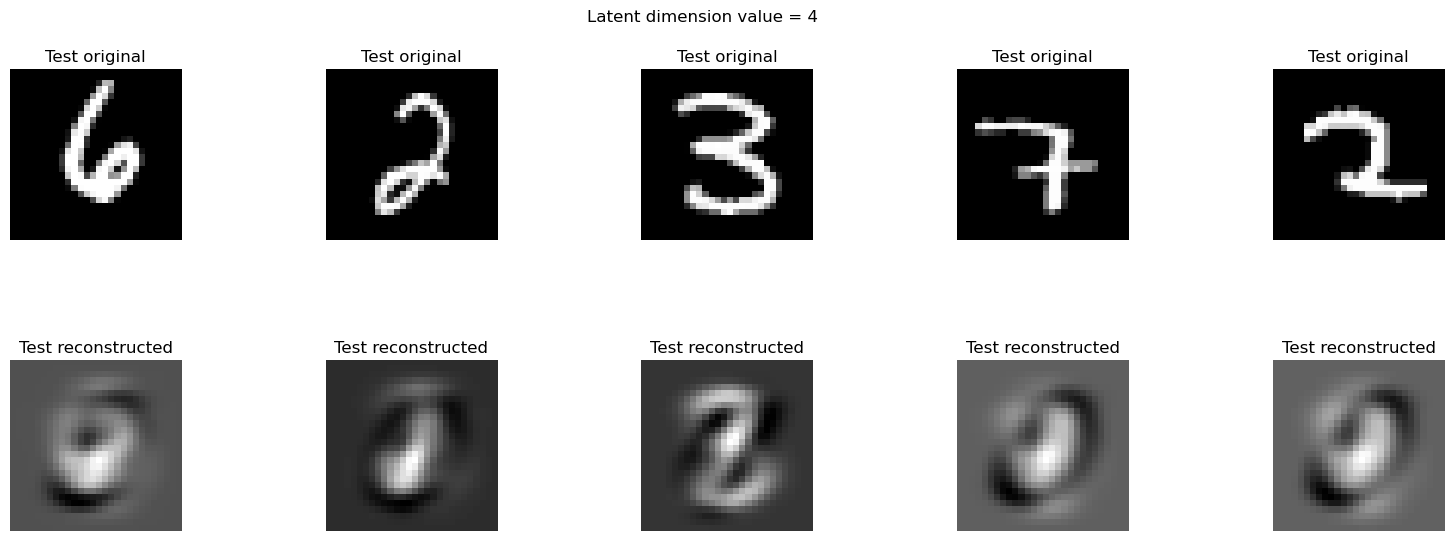

MSE val for latent dimension 8 is 0.07750603873774006


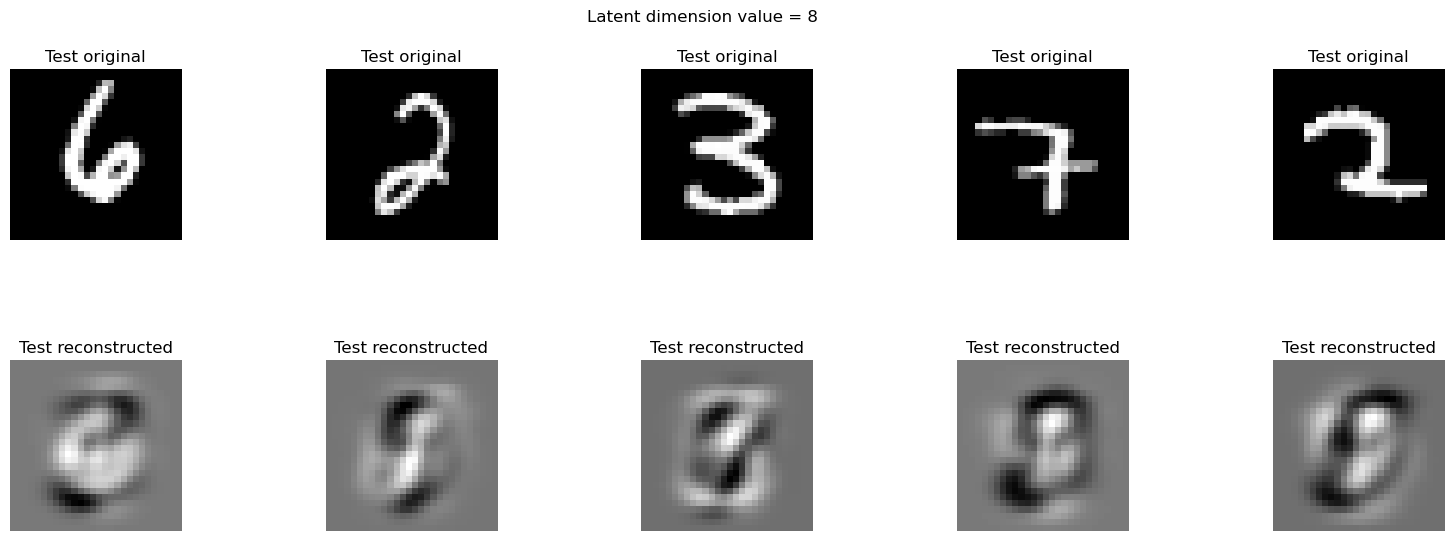

MSE val for latent dimension 16 is 0.07191685113844348


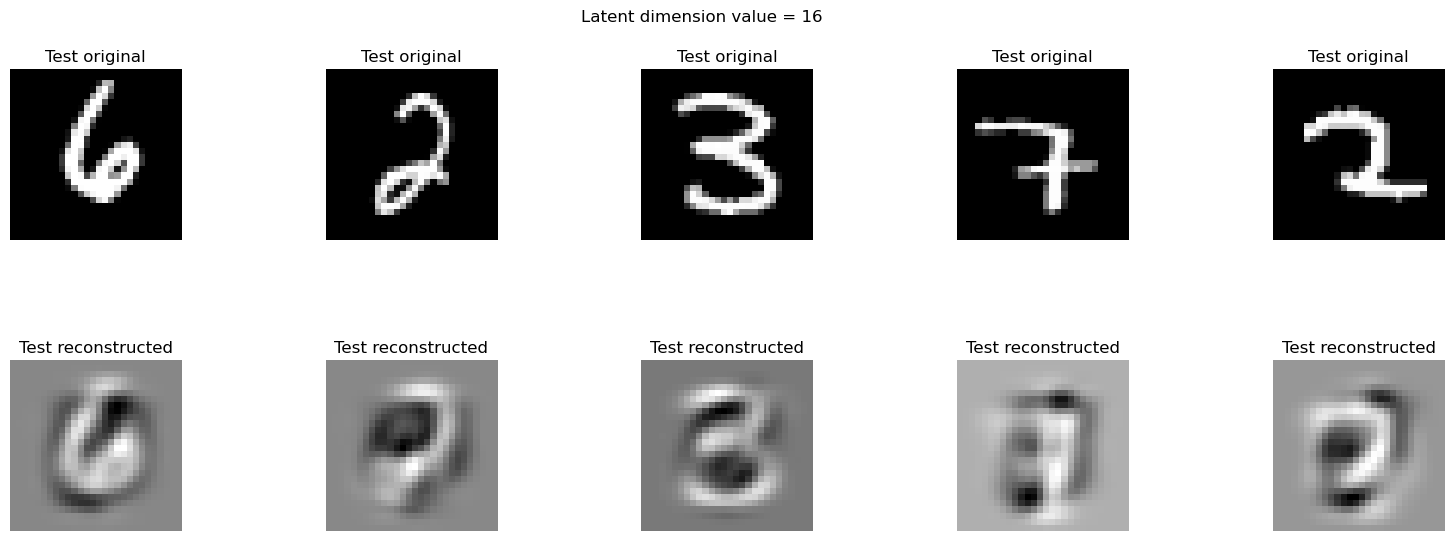

MSE val for latent dimension 32 is 0.06303978544636066


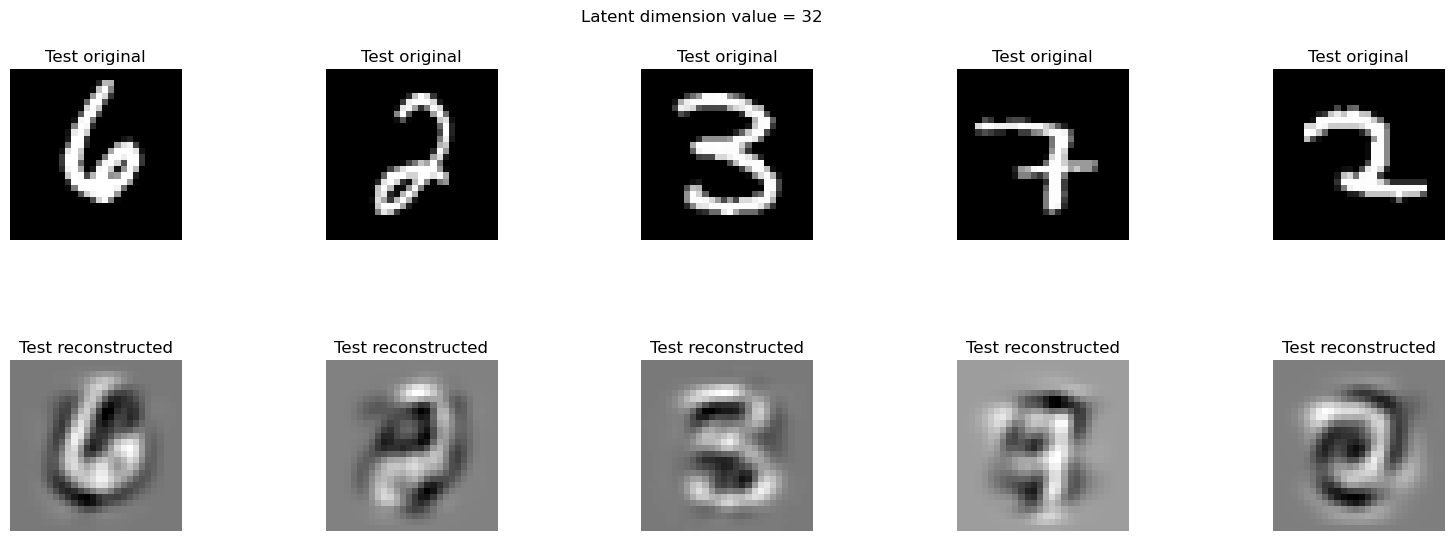

MSE val for latent dimension 64 is 0.05548393574838489


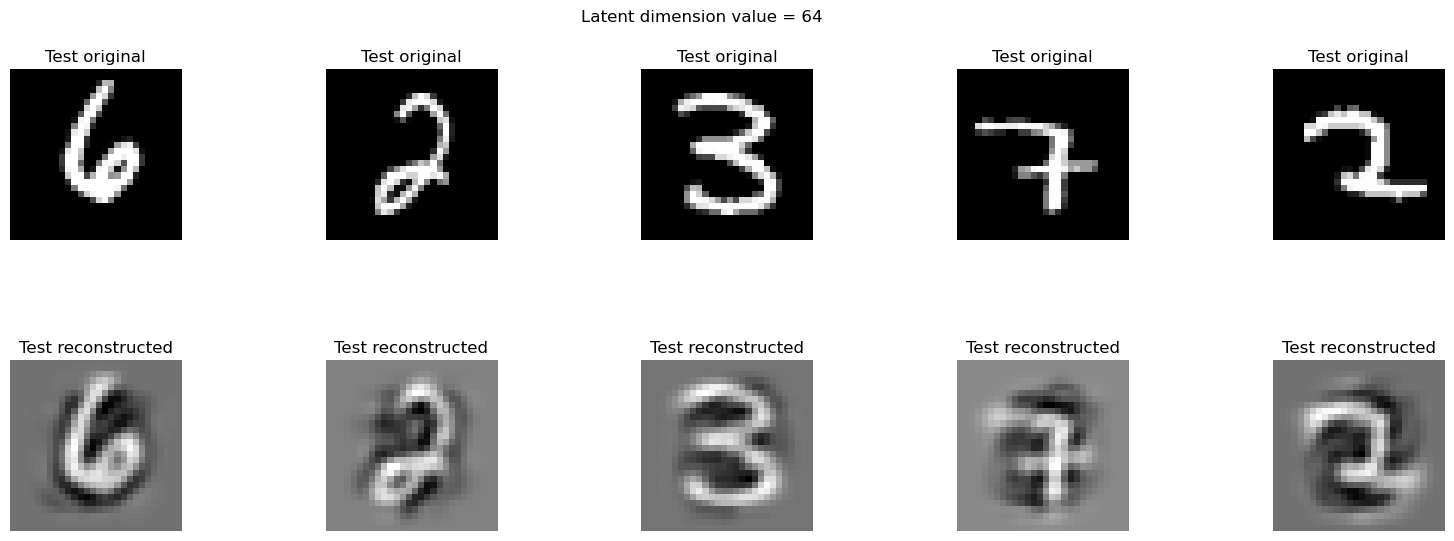

In [3]:
import matplotlib.pyplot as plt

latentDimensions = [2, 4, 8, 16, 32, 64]

def probabilisticPCA(centeredTrainImages, latentDimensionValue):
    '''numSamples = normalizedTrainImages.shape[0]
    trainMean = np.mean(normalizedTrainImages, axis = 0)
    covarianceMatrix = np.zeros((normalizedTrainImages.shape[1], normalizedTrainImages.shape[1]))
    imgCount = 0
    for image in normalizedTrainImages:
        imgCount = imgCount + 1
        print(imgCount)

        image = image.reshape(-1,1)
        covarianceMatrix += np.dot(image - trainMean, (image - trainMean.T))

    covarianceMatrix = covarianceMatrix / numSamples'''
    covarianceMatrix = (centeredTrainImages.T @ centeredTrainImages) / len(centeredTrainImages)

    #nan_indices = np.where(np.isnan(covarianceMatrix))
    #print("Indices with NaN in Covariance Matrix:", nan_indices)


    #print("Any NaN in Covariance Matrix:", np.any(np.isnan(covarianceMatrix)))       
    
    eigenValues, eigenVectors = np.linalg.eigh(covarianceMatrix)


    Um = eigenVectors[:, -latentDimensionValue:]    
    Lm = np.diag(eigenValues[-latentDimensionValue:])   #Diagonal matrix of eigenvalues

    I = np.eye(latentDimensionValue)
    sigmaSquare = abs(np.mean(np.sum(eigenVectors) - np.sum(Um)))
    R = I  # Since its arbitrary, we take R as an identity matrix
    
    weights = Um @ np.sqrt(abs(Lm - sigmaSquare * I)) @ R

    return weights

def imageReconstruction(testImages, weights, mean, sigma, latentDimensionValue):

    #Z, residuals, _, _ = np.linalg.lstsq(weights.T @ weights + 1e-5 * np.eye(weights.shape[1]), weights.T @ (normalizedImages - mean).T, rcond=None) 
    #print("Weights.T @ Weights:", weights.T @ weights)
    #print("Weights.T @ (normalizedImages - mean).T:", weights.T @ (normalizedImages - mean).T)

    #Z = np.linalg.solve((weights.T @ weights), (weights.T) @ (normalizedImages - mean).T) 
    #X = WZ + u
    #return (weights @ Z).T + mean

    M = weights.T @ weights + sigma**2 * np.eye(latentDimensionValue)

    z = (np.linalg.inv(M) @ weights.T @ (testImages - mean).T)

    K = (weights @ (np.linalg.inv(weights.T @ weights)) @ M @ z).T
    x_pred = K + mean.reshape(-1,1).T
    return x_pred

trainMean = np.mean(flattenedTrainImages, axis = 0)
#standardDev = np.std(flattenedTrainImages, axis = 0)
#N = flattenedTrainImages.shape[0]
#D = flattenedTrainImages.shape[1]
sigma = 1.0
testMean = np.mean(flattenedTestImages, axis = 0)

centeredTrainImages = flattenedTrainImages - trainMean
centeredTestImages = (flattenedTestImages - testMean)

ppca_mse_values_list = []

for latentDimensionValue in latentDimensions:

     
    weights = probabilisticPCA(centeredTrainImages, latentDimensionValue)
    reconstructedImages = imageReconstruction(centeredTestImages, weights, testMean, sigma, latentDimensionValue) 
    mseSum = 0

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent dimension value = {latentDimensionValue}")
    #print(reconstructedImages.shape)
    
    for idx in range(len(centeredTestImages)):
        #print(normalizedTestImages[idx])
        #print(reconstructedImage)
        mseVal = np.mean((flattenedTestImages[idx] - reconstructedImages[idx])**2)
        mseSum += mseVal
        
    finalMse = (mseSum) / len(centeredTestImages)
    ppca_mse_values_list.append(finalMse)
    print("MSE val for latent dimension {} is {}".format(latentDimensionValue,finalMse))

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(flattenedTestImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')    #reshaping the 1d array back to 2d for accessing
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
    
ppca_mse_values_array = np.array(ppca_mse_values_list)

## VARIATIONAL AUTOENCODER IMPLEMENTATION

Epoch 1/10
600/600 [==============================] - 9s 10ms/step - loss: 190.5465 - val_loss: 166.6683
Epoch 2/10
600/600 [==============================] - 5s 9ms/step - loss: 162.1071 - val_loss: 158.0282
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 155.4555 - val_loss: 153.2583
Epoch 4/10
600/600 [==============================] - 5s 8ms/step - loss: 151.5298 - val_loss: 150.9292
Epoch 5/10
600/600 [==============================] - 5s 8ms/step - loss: 148.6135 - val_loss: 147.8132
Epoch 6/10
600/600 [==============================] - 5s 8ms/step - loss: 146.5125 - val_loss: 146.4026
Epoch 7/10
600/600 [==============================] - 5s 8ms/step - loss: 145.0262 - val_loss: 144.8858
Epoch 8/10
600/600 [==============================] - 5s 9ms/step - loss: 143.9229 - val_loss: 143.5682
Epoch 9/10
600/600 [==============================] - 5s 8ms/step - loss: 142.9869 - val_loss: 143.3898
Epoch 10/10
313/313 [==============================] - 1s 2ms/s

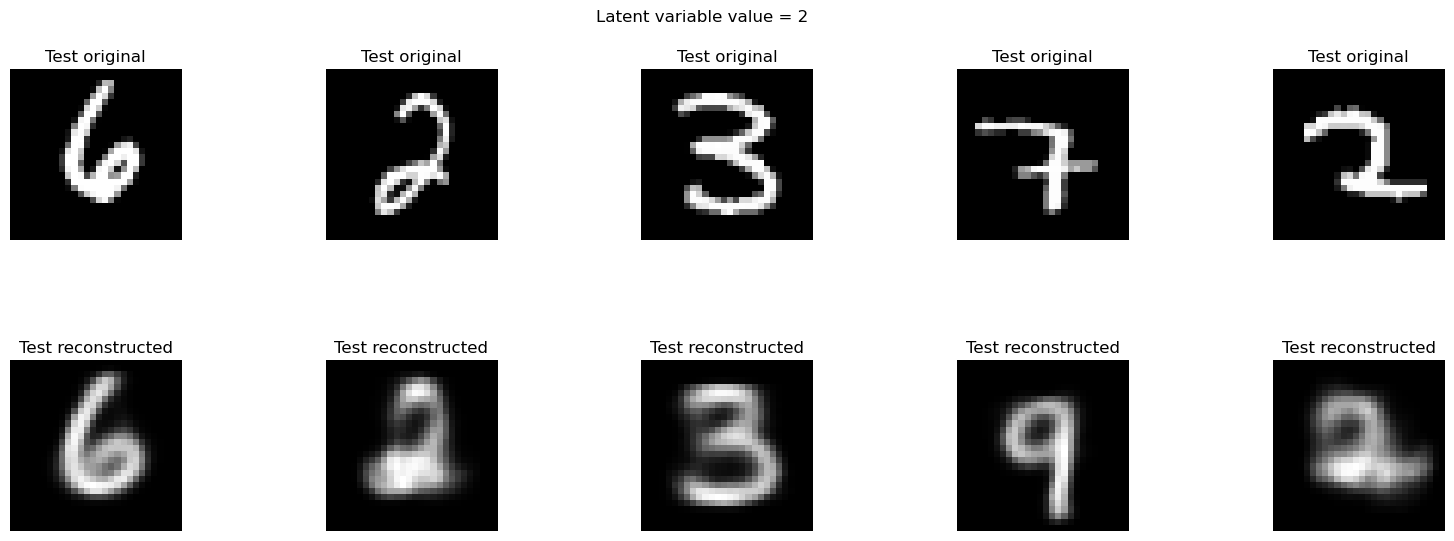

Epoch 1/10
600/600 [==============================] - 7s 9ms/step - loss: 169.4231 - val_loss: 144.8837
Epoch 2/10
600/600 [==============================] - 5s 8ms/step - loss: 139.6180 - val_loss: 134.2571
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 133.0674 - val_loss: 130.1781
Epoch 4/10
600/600 [==============================] - 5s 9ms/step - loss: 129.3151 - val_loss: 127.3509
Epoch 5/10
600/600 [==============================] - 5s 9ms/step - loss: 126.7211 - val_loss: 125.6490
Epoch 6/10
600/600 [==============================] - 5s 9ms/step - loss: 124.8918 - val_loss: 124.1021
Epoch 7/10
600/600 [==============================] - 5s 9ms/step - loss: 123.5043 - val_loss: 122.9744
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 122.4069 - val_loss: 122.1114
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 121.5002 - val_loss: 122.1500
Epoch 10/10
313/313 [==============================] - 2s 5ms/

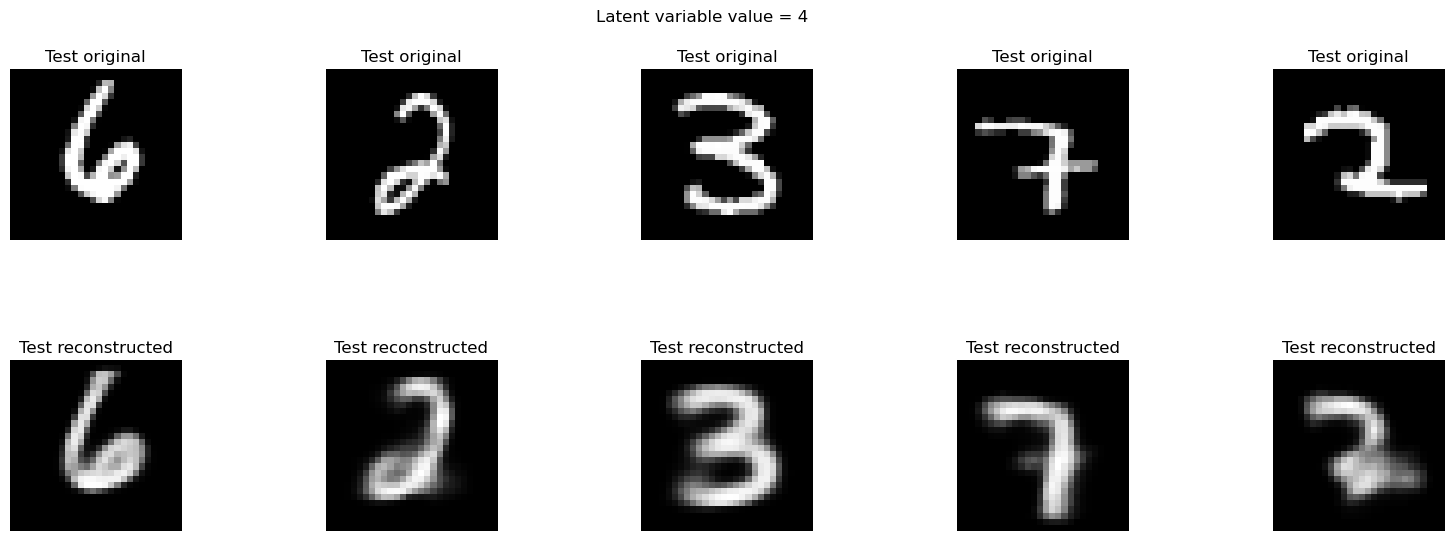

Epoch 1/10
600/600 [==============================] - 9s 12ms/step - loss: 166.7084 - val_loss: 134.1490
Epoch 2/10
600/600 [==============================] - 6s 11ms/step - loss: 127.1027 - val_loss: 120.5214
Epoch 3/10
600/600 [==============================] - 7s 11ms/step - loss: 118.1983 - val_loss: 115.2781
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 113.5598 - val_loss: 110.3157
Epoch 5/10
600/600 [==============================] - 5s 9ms/step - loss: 110.4940 - val_loss: 108.6074
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 108.3018 - val_loss: 106.3506
Epoch 7/10
600/600 [==============================] - 6s 10ms/step - loss: 106.7205 - val_loss: 106.0665
Epoch 8/10
600/600 [==============================] - 6s 10ms/step - loss: 105.4543 - val_loss: 104.3539
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 104.4923 - val_loss: 103.5473
Epoch 10/10
313/313 [==============================] - 1

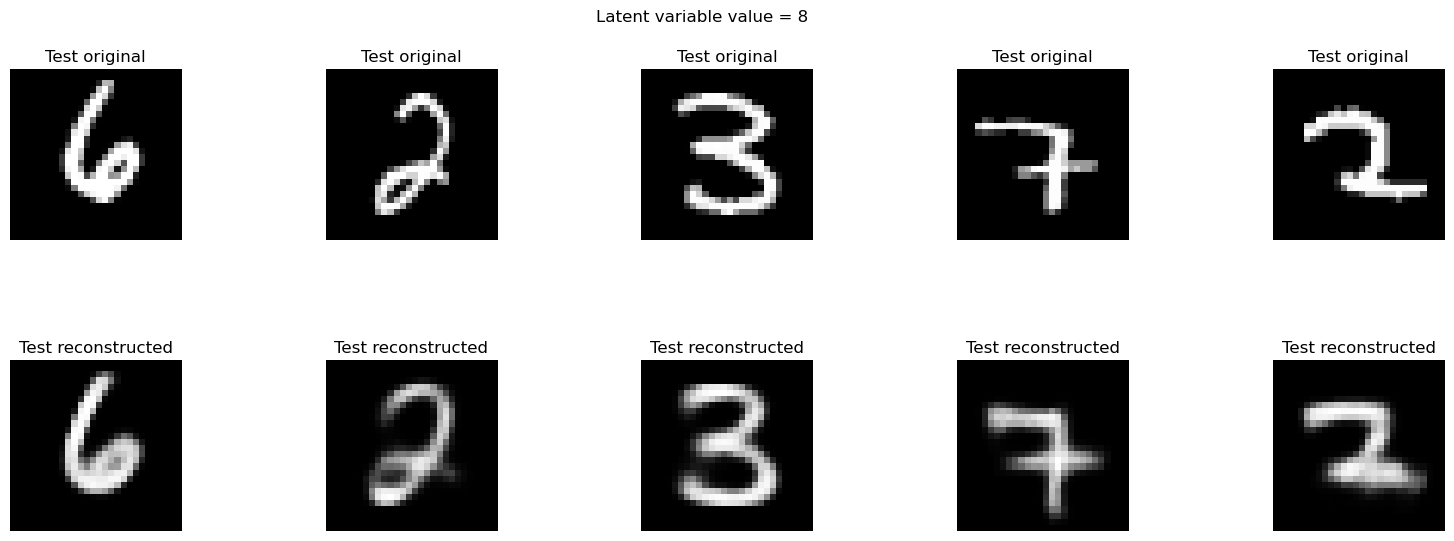

Epoch 1/10
600/600 [==============================] - 10s 13ms/step - loss: 161.7608 - val_loss: 131.6027
Epoch 2/10
600/600 [==============================] - 5s 9ms/step - loss: 123.6418 - val_loss: 115.8312
Epoch 3/10
600/600 [==============================] - 5s 9ms/step - loss: 112.9039 - val_loss: 109.4810
Epoch 4/10
600/600 [==============================] - 5s 9ms/step - loss: 107.3046 - val_loss: 104.4285
Epoch 5/10
600/600 [==============================] - 8s 13ms/step - loss: 103.9978 - val_loss: 103.6592
Epoch 6/10
600/600 [==============================] - 8s 13ms/step - loss: 101.8146 - val_loss: 100.6769
Epoch 7/10
600/600 [==============================] - 7s 12ms/step - loss: 100.2607 - val_loss: 100.6247
Epoch 8/10
600/600 [==============================] - 7s 12ms/step - loss: 99.0601 - val_loss: 97.0117
Epoch 9/10
600/600 [==============================] - 6s 10ms/step - loss: 98.0740 - val_loss: 96.8865
Epoch 10/10
313/313 [==============================] - 1s 2ms

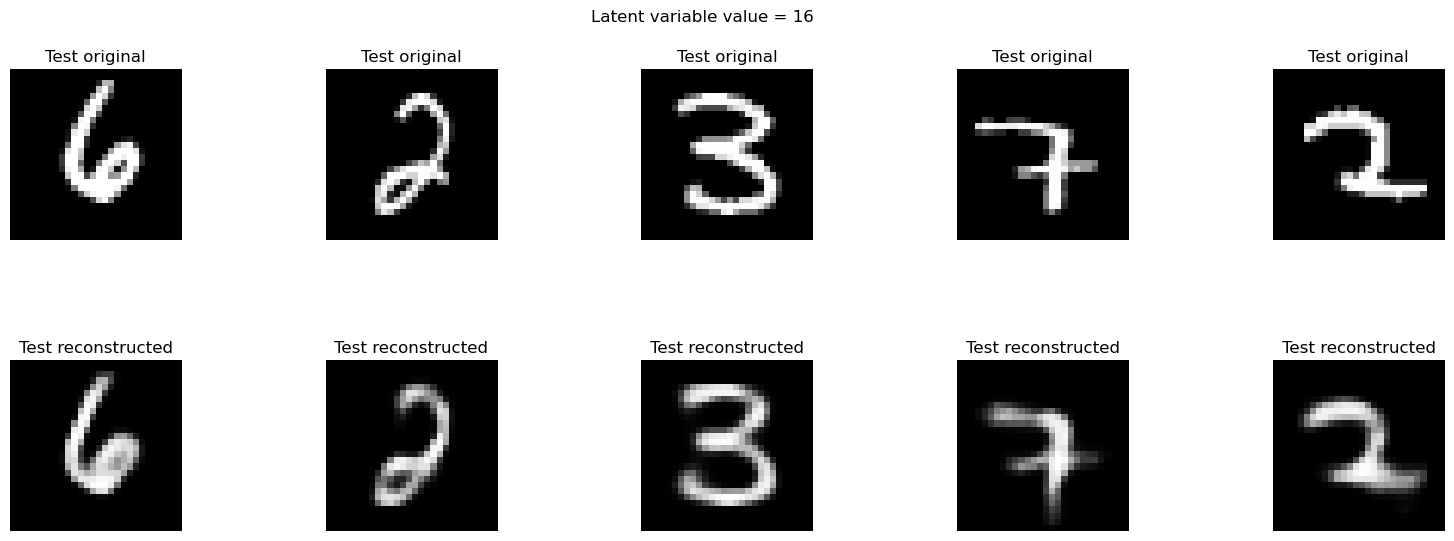

Epoch 1/10
600/600 [==============================] - 8s 11ms/step - loss: 163.3452 - val_loss: 134.3391
Epoch 2/10
600/600 [==============================] - 6s 10ms/step - loss: 125.6690 - val_loss: 116.2418
Epoch 3/10
600/600 [==============================] - 6s 9ms/step - loss: 113.9060 - val_loss: 111.3254
Epoch 4/10
600/600 [==============================] - 5s 9ms/step - loss: 107.5596 - val_loss: 104.3216
Epoch 5/10
600/600 [==============================] - 5s 9ms/step - loss: 103.7820 - val_loss: 101.6121
Epoch 6/10
600/600 [==============================] - 5s 9ms/step - loss: 101.3680 - val_loss: 100.4868
Epoch 7/10
600/600 [==============================] - 6s 11ms/step - loss: 99.5261 - val_loss: 101.1239
Epoch 8/10
600/600 [==============================] - 7s 12ms/step - loss: 98.1592 - val_loss: 97.8496
Epoch 9/10
600/600 [==============================] - 7s 11ms/step - loss: 97.0580 - val_loss: 94.8203
Epoch 10/10
313/313 [==============================] - 1s 2ms/st

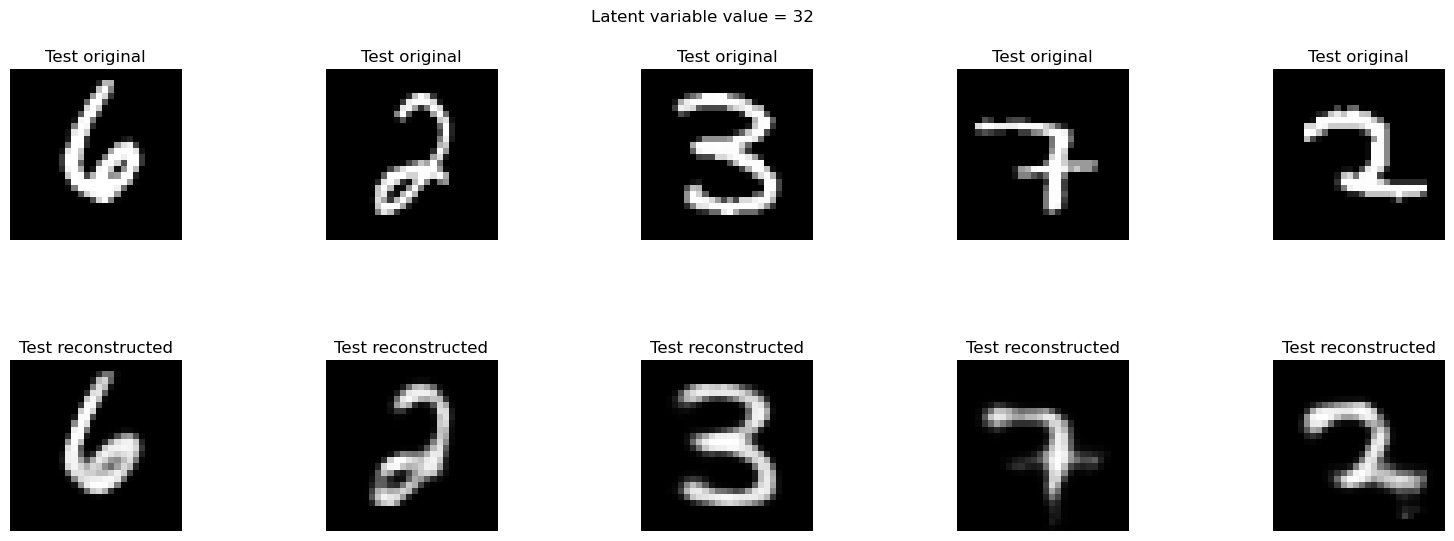

Epoch 1/10
600/600 [==============================] - 11s 13ms/step - loss: 167.3555 - val_loss: 140.9905
Epoch 2/10
600/600 [==============================] - 7s 12ms/step - loss: 130.7157 - val_loss: 121.8557
Epoch 3/10
600/600 [==============================] - 7s 12ms/step - loss: 118.4116 - val_loss: 112.2592
Epoch 4/10
600/600 [==============================] - 6s 10ms/step - loss: 111.3669 - val_loss: 107.5658
Epoch 5/10
600/600 [==============================] - 6s 10ms/step - loss: 106.8313 - val_loss: 104.5323
Epoch 6/10
600/600 [==============================] - 6s 10ms/step - loss: 103.5843 - val_loss: 101.5337
Epoch 7/10
600/600 [==============================] - 6s 11ms/step - loss: 101.1267 - val_loss: 101.0304
Epoch 8/10
600/600 [==============================] - 6s 9ms/step - loss: 99.3916 - val_loss: 98.7072
Epoch 9/10
600/600 [==============================] - 6s 9ms/step - loss: 98.0278 - val_loss: 98.7232
Epoch 10/10
313/313 [==============================] - 1s 2m

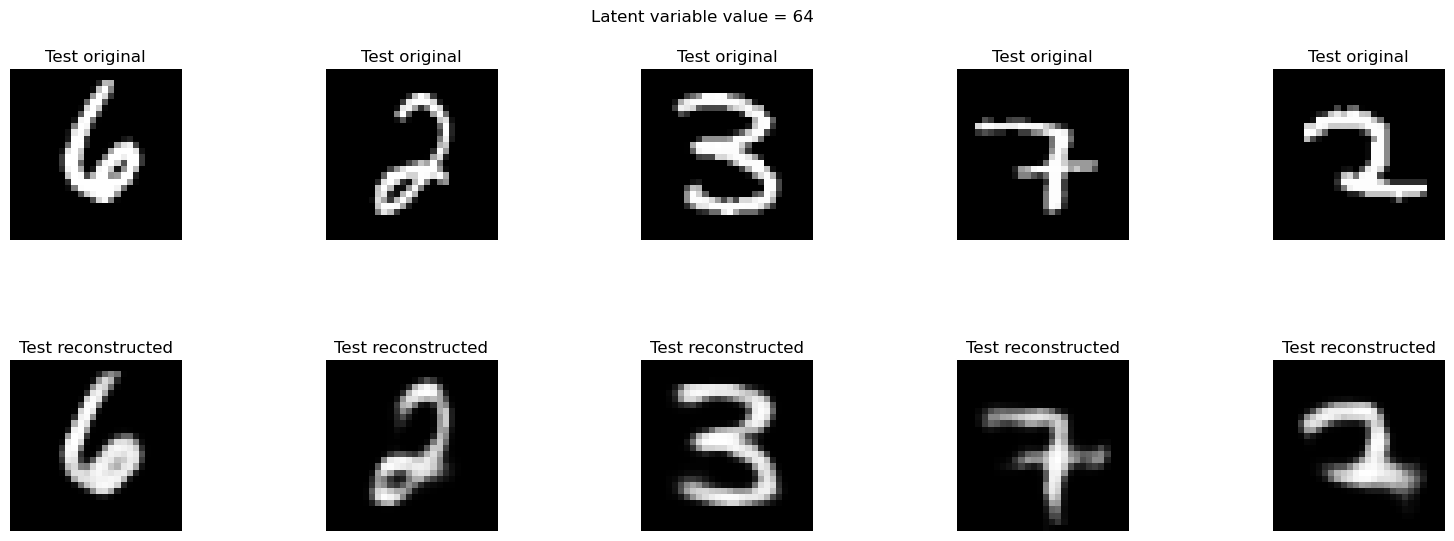

In [4]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from keras.datasets import mnist
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from scipy.stats import norm

latentDimensions = [2, 4, 8, 16, 32, 64]
# latentDimensions = [2]
randomImages = random.sample(range(len(testImages)), 5)

batch_size, epoch = 100, 10
n_hidden = 256

def normalization(flattenedTrainImages):
    mean = np.mean(flattenedTrainImages, axis = 0)
    standardDev = np.std(flattenedTrainImages, axis = 0)

    #Handle 0 variance here, else NaN values are produced
    zeroVarianceIndices = np.where(standardDev == 0)[0]
    standardDev[zeroVarianceIndices] = 1e-5

    normalizedImages = (flattenedTrainImages - mean) / standardDev
    return normalizedImages, mean, standardDev

def variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue):
    
    x = Input(shape=(flattenedTrainImages.shape[1:]))
    h1 = Dense(256, activation='relu')(x)
    h1 = Dense(128, activation='relu')(h1)

    mu = Dense(latentDimensionValue)(h1)
    log_var = Dense(latentDimensionValue)(h1)

    def sampling(args):
        mu, log_var = args
        eps = K.random_normal(shape=(batch_size, latentDimensionValue), mean=0., stddev=1.0)
        return mu + K.exp(log_var) * eps

    z = Lambda(sampling, output_shape=(latentDimensionValue,))([mu, log_var])

    z1 = Dense(128, activation='relu')
    z2 = Dense(256, activation='relu')
    y_decoder = Dense(flattenedTrainImages.shape[1], activation='sigmoid')

    h2 = z1(z)
    h2 = z2(h2)
    y = y_decoder(h2)

    kl_loss = 0.5 * K.sum(K.square(mu) + K.exp(log_var) - log_var - 1, axis = -1)
    reconstruction_loss = K.sum(K.binary_crossentropy(x, y), axis=-1)

    vae_loss = reconstruction_loss + kl_loss

    vae = Model(x, y)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop')

    vae.fit(flattenedTrainImages,epochs=epoch,batch_size=batch_size,validation_data=(flattenedTestImages, None), verbose=1)

    encoder = Model(x, mu)
    z_latent = encoder.predict(flattenedTestImages, batch_size=batch_size)

    decoder_input = Input(shape=(latentDimensionValue,))
    h3 = z1(decoder_input)
    h3 = z2(h3)
    generatedImage = y_decoder(h3)
    generator = Model(decoder_input, generatedImage)

    reconstructed = generator.predict(z_latent)
    
    return reconstructed


normalizedTrainImages, mean, standardDev = normalization(flattenedTrainImages)
VAE_mse_values_list = []
for latentDimensionValue in latentDimensions:

    normalizedTestImages = (flattenedTestImages - mean) / standardDev
    reconstructedImages = variationalAutoEncoder(flattenedTrainImages, flattenedTestImages, latentDimensionValue)
    mseVal = np.mean(np.square(flattenedTestImages - reconstructedImages))
    VAE_mse_values_list.append(mseVal)
    print("MSE for latent dimension {} is: {}".format(latentDimensionValue,mseVal))

    plt.figure(figsize=(20,6))
    plt.suptitle(f"Latent variable value = {latentDimensionValue}")

    for i, idx in enumerate(selectedImages):
        plt.subplot(2, 5, i + 1)
        plt.imshow(testImages[idx], cmap='gray')
        plt.title(f"Test original")
        plt.axis('off') #Removes x and y axis labels

        plt.subplot(2, 5, i + 6)
        # reconstructed_image_np = reconstructedImages[idx].numpy()
        plt.imshow(reconstructedImages[idx].reshape(28,28), cmap='gray')
        plt.title(f"Test reconstructed")
        plt.axis('off')

    plt.subplots_adjust(hspace=0.7, wspace=0.1)
    plt.show()
VAE_mse_values_array = np.array(VAE_mse_values_list)

## GRAPH PLOTTING

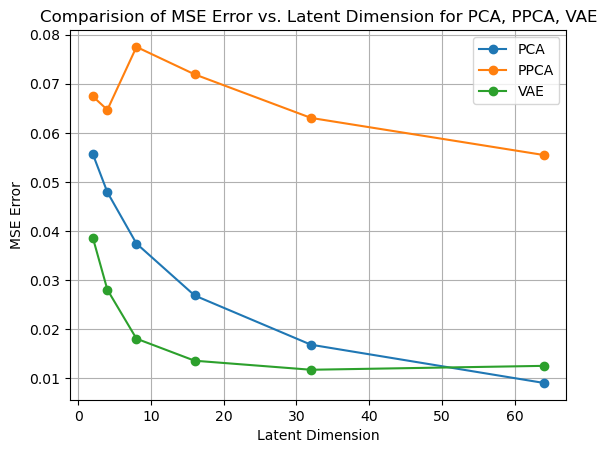

In [5]:
import numpy as np
import matplotlib.pyplot as plt

latent_dimensions = [2, 4, 8, 16, 32, 64]

# Plotting
plt.plot(latent_dimensions, mse_values_array, marker='o', label = 'PCA')
plt.plot(latent_dimensions, ppca_mse_values_array, marker='o', label = 'PPCA')
plt.plot(latent_dimensions, VAE_mse_values_array, marker='o', label = 'VAE')
plt.legend()
plt.xlabel('Latent Dimension')
plt.ylabel('MSE Error')
plt.title('Comparision of MSE Error vs. Latent Dimension for PCA, PPCA, VAE')
plt.grid(True)
plt.show()